# Tiny Benchmark

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


This notebook is used to test small performance differences in **RxInfer.jl** during the development process for a very simple model. This benchmark does not represent the whole range of possible regressions but it is quick and easy to execute.

In [2]:
using RxInfer, BenchmarkTools, Random, Plots

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1664


## Synthetic dataset

In [3]:
seed = 123

rng = MersenneTwister(seed)

v = 100.0

n = 500

hidden     = collect(1:n)
data       = hidden + rand(rng, Normal(0.0, sqrt(v)), n);
datastream = from(data) |> map(NamedTuple{(:y, ), Tuple{Float64}}, (d) -> (y = d, ));

## Filtering

In [4]:
@model function filtering(; c::ConstVariable, v::ConstVariable)
    
    x_prior_mean = datavar(Float64)
    x_prior_var  = datavar(Float64)
    
    x_prior ~ Normal(mean = x_prior_mean, variance = x_prior_var) 
    x_next ~ x_prior + c
    
    y = datavar(Float64)
    y ~ Normal(mean = x_next, variance = v)
    
end

In [5]:
function run_filtering(datastream, n, v)
    
    autoupdates = @autoupdates begin 
        x_prior_mean, x_prior_var = mean_var(q(x_next))
    end

    return rxinference(
        model       = filtering(c = 1.0, v = v),
        datastream  = datastream,
        autoupdates = autoupdates,
        initmarginals = (x_next = NormalMeanVariance(0.0, 10000.0), ),
        keephistory = n,
        historyvars = (x_next = KeepLast(), ),
        free_energy = true,
        autostart = true,
        postprocess = UnpackMarginalPostprocess()
    )
    
end

run_filtering (generic function with 1 method)

In [6]:
result_filtering = run_filtering(datastream, n, v)

RxInferenceEngine:
  Posteriors stream    | enabled for (x_next, x_prior)
  Free Energy stream   | enabled
  Posteriors history   | available for (x_next)
  Free Energy history  | available
  Enabled events       | [  ]

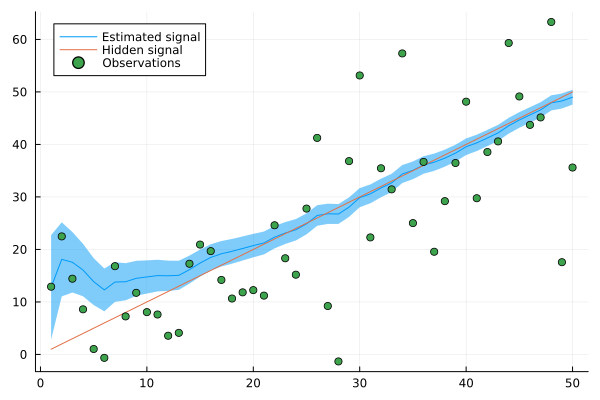

In [7]:
let 
    results = result_filtering.history[:x_next]
    subrange = 1:50
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

## Smoothing

In [8]:
@model function smoothing(n; c::ConstVariable, v::ConstVariable)
    
    x_prior ~ Normal(mean = 0.0, variance = 10000.0) 

    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ Normal(mean = x[i], variance = v)
        x_prev = x[i]
    end
    
    return x, y
end

In [9]:
function run_smoothing(data, n, v)
    return inference(
        model = smoothing(n, c = 1.0, v = v), 
        data  = (y = data, ), 
        returnvars = KeepLast(),
        free_energy = true,
        postprocess = UnpackMarginalPostprocess()
    )
end

run_smoothing (generic function with 1 method)

In [10]:
result_smoothing = run_smoothing(data, n, v)

Inference results:
  Posteriors       | available for (x_prior, x)
  Free Energy:     | Real[1896.16]


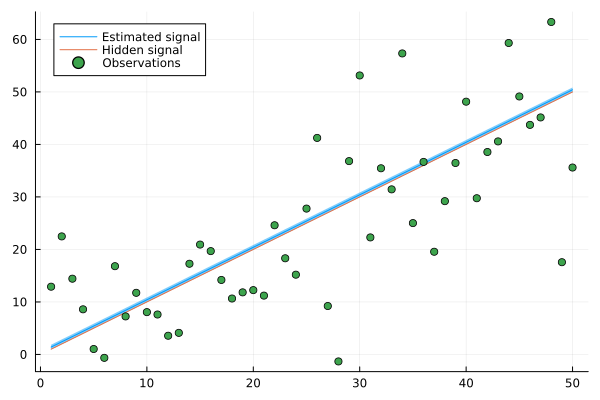

In [11]:
let 
    results = result_smoothing.posteriors[:x]
    subrange = 1:50
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

# Benchmarks

In [12]:
@benchmark run_filtering($datastream, $n, $v)

BenchmarkTools.Trial: 899 samples with 1 evaluation.
 Range (min … max):  4.310 ms … 21.838 ms  ┊ GC (min … max): 0.00% … 67.84%
 Time  (median):     5.158 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.553 ms ±  2.399 ms  ┊ GC (mean ± σ):  6.68% ± 11.38%

  ▁ ▇█▂                                                       
  █████▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂ ▃
  4.31 ms        Histogram: frequency by time        19.9 ms <

 Memory estimate: 3.45 MiB, allocs estimate: 85342.

In [13]:
@benchmark run_smoothing($data, $n, $v)

BenchmarkTools.Trial: 248 samples with 1 evaluation.
 Range (min … max):  15.741 ms … 45.750 ms  ┊ GC (min … max): 0.00% … 51.87%
 Time  (median):     18.590 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.196 ms ±  5.869 ms  ┊ GC (mean ± σ):  8.16% ± 13.73%

  █▄▃▇▄▄▄▁▄▂▁▆                                                 
  █████████████▅▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▃▃▃▃▃▃▁▃▃▁▄▁▃▃▃ ▃
  15.7 ms         Histogram: frequency by time        40.8 ms <

 Memory estimate: 12.56 MiB, allocs estimate: 247416.